## 1.Load the data

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tweepy
import datetime
import calendar
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

DIR = "./data/"
EGO_TIMELINES = DIR + "EgoTimelines.txt"
EGO_ALTER_PROFILES = DIR + "EgoAlterProfiles.txt"

ego_timelines = pd.read_csv(EGO_TIMELINES, sep='\t',encoding = "ISO-8859-1")
ego_alter = pd.read_csv( EGO_ALTER_PROFILES, sep='\t',encoding = "ISO-8859-1")

## 2.Merge the ego's timelines and profiles

This part is similar to the one some of us did in the replication part of P4. 

In the first part, we want to change the strings in `created_at` to datetimes.

In [7]:
ego_timelines['created_at'] = ego_timelines['created_at'].apply(lambda x: x.replace('+0000', ''))
ego_timelines['created_at'] = ego_timelines['created_at'].apply(lambda x: datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %Y"))

In [8]:
ego_alter['created_at'] = ego_alter['created_at'].apply(lambda x: x.replace('+0000', ''))
ego_alter['created_at'] = ego_alter['created_at'].apply(lambda x: datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %Y"))

We decided not to follow the step from the replication to use only egos which have a defined `utc_offset` as we reckon it does not affect our result too much, it would only affect tweets made on the first or last day of the month.

In [9]:
egos_only = ego_alter[ego_alter['IsEgo']]

We merge the two datasets, based on the ID that was assigned to them by the authors of the paper.

In [10]:
merged = ego_timelines.merge(egos_only, left_on = 'egoID', right_on = 'ID', suffixes = ('_timelines', '_profiles'))

We add three columns representing the month and the year at which the tweet was posted and the year at which the account was created.

In [11]:
merged['month_post'] = merged['created_at_timelines'].apply(lambda x: calendar.month_abbr[x.month])
merged['year_post'] = merged['created_at_timelines'].apply(lambda x: x.year)
merged['year_account'] = merged['created_at_profiles'].apply(lambda x: x.year)

In [12]:
merged.head()

,replyto_userid,retweeted_userid,id,tweetid,created_at_timelines,hashtags,urls,mentions_ids,retweet_count,egoID,...,followers_count,friends_count,statuses_count,utc_offset,lang,created_at_profiles,protected,month_post,year_post,year_account
0,NaN,NaN,398477318,249552537051598848,2012-09-22 16:55:35,NaN,NaN,2810549959,0,1,...,30.0,28,9.0,NaN,en,2011-10-26 03:30:32,False,Sep,2012,2011
1,NaN,NaN,398477318,249537963145433088,2012-09-22 15:57:41,NaN,NaN,2810549959,0,1,...,30.0,28,9.0,NaN,en,2011-10-26 03:30:32,False,Sep,2012,2011
2,NaN,NaN,398477318,129377372209299456,2011-10-27 02:02:23,NaN,NaN,NaN,0,1,...,30.0,28,9.0,NaN,en,2011-10-26 03:30:32,False,Oct,2011,2011
3,NaN,NaN,398477318,302401054690140160,2013-02-15 12:56:44,NaN,NaN,797583722,0,1,...,30.0,28,9.0,NaN,en,2011-10-26 03:30:32,False,Feb,2013,2011
4,NaN,NaN,398477318,249538739611787264,2012-09-22 16:00:46,NaN,NaN,2810549959,0,1,...,30.0,28,9.0,NaN,en,2011-10-26 03:30:32,False,Sep,2012,2011


## 3.Barplot of the number of tweets per month

We will select only the tweets of a given year, done by user which account was created before the start of this year. This is done as a way to reduce bias as a user whose account was created in June could not have posted any tweets before.

In [13]:
month_count_2011 = merged['month_post'][(merged['year_post'] == 2011) & (merged['year_account'] < 2011)].value_counts()
month_count_2012 = merged['month_post'][(merged['year_post'] == 2012) & (merged['year_account'] < 2012)].value_counts()
month_count_2013 = merged['month_post'][(merged['year_post'] == 2013) & (merged['year_account'] < 2013)].value_counts()

We sort the counts by the months so that we can generate graph that can be read from left to right

In [47]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

month_count_2011 = month_count_2011.reindex(months, axis=0)
month_count_2012 = month_count_2012.reindex(months, axis=0)
month_count_2013 = month_count_2013.reindex(months, axis=0)

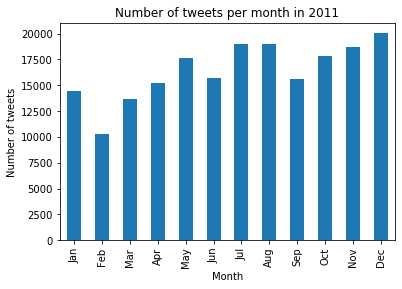

In [48]:

month_count_2011.plot.bar()
plt.title("Number of tweets per month in 2011")
plt.xlabel("Month")
plt.ylabel("Number of tweets")
plt.savefig("month2011.png")

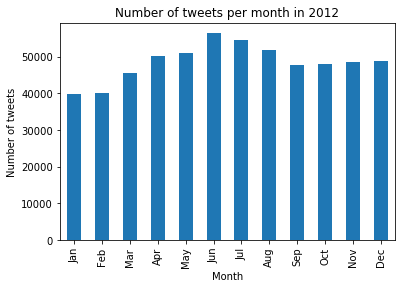

In [49]:
month_count_2012.plot.bar()
plt.title("Number of tweets per month in 2012")
plt.xlabel("Month")
plt.ylabel("Number of tweets")
plt.savefig("month2012.png")

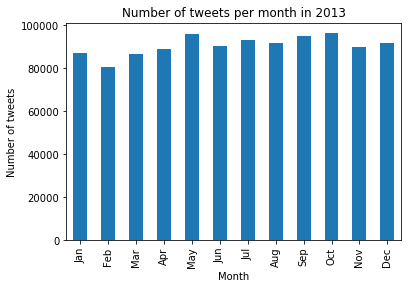

In [50]:
month_count_2013.plot.bar()
plt.title("Number of tweets per month in 2013")
plt.xlabel("Month")
plt.ylabel("Number of tweets")
plt.savefig("month2013.png")

We observe multiple things:
* The number of tweets increases each year pretty drastically. The more tweets, the more the distribution between the months seems uniform
* The month with less activity seems to be the first month of the year

In [56]:
month_count_2011.index[month_count_2011.argmax()]

'Dec'

In [57]:
month_count_2012.index[month_count_2012.argmax()] 

'Jun'

In [58]:
month_count_2013.index[month_count_2013.argmax()]

'Oct'

We cannot deduce from these plots that there is some kind of Circadian rhythms in the months. However what seems to be more realistic, is that people tend to react according to what happens during the year. Take for example the [EURO 2012](https://en.wikipedia.org/wiki/UEFA_Euro_2012) which happened during the month of June and July . This year, the spanish team won the cup. Let's see if it has influenced how much they've published in june compared to other years:

In [90]:
#Take all people that have put as their main language spanish
spanish_tweets_2011 = merged['month_post'][(merged['year_post'] == 2011) & (merged['year_account'] < 2011) &\
                                        (merged['lang'] == 'es' )].value_counts()

spanish_tweets_2012 = merged['month_post'][(merged['year_post'] == 2012) & (merged['year_account'] < 2012) &\
                                        (merged['lang'] == 'es' )].value_counts()
spanish_tweets_2013 = merged['month_post'][(merged['year_post'] == 2013) & (merged['year_account'] < 2013) &\
                                        (merged['lang'] == 'es' )].value_counts()

spanish_tweets_2011 = spanish_tweets_2011.reindex(months, axis = 0)
spanish_tweets_2012 = spanish_tweets_2012.reindex(months, axis = 0)
spanish_tweets_2013 = spanish_tweets_2013.reindex(months, axis = 0)

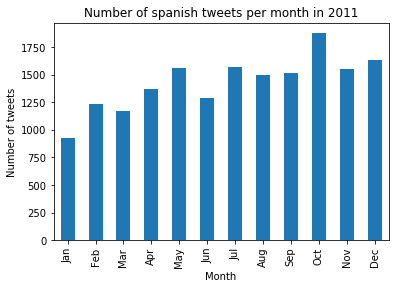

In [95]:
spanish_tweets_2011.plot.bar()
plt.title("Number of spanish tweets per month in 2011")
plt.xlabel("Month")
plt.ylabel("Number of tweets")
plt.savefig("spanish2011.png")

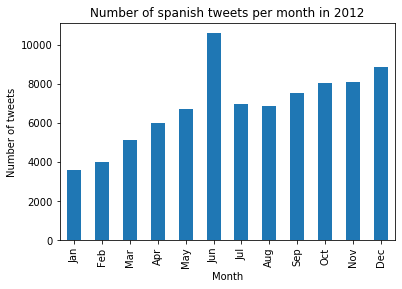

In [98]:
spanish_tweets_2012.plot.bar()
plt.title("Number of spanish tweets per month in 2012")
plt.xlabel("Month")
plt.ylabel("Number of tweets")
plt.savefig("spanish2012.png")

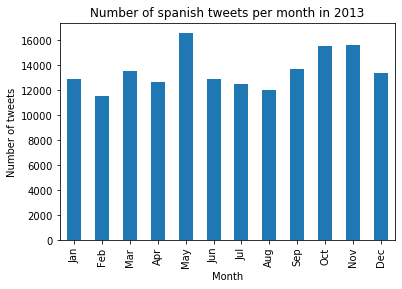

In [97]:
spanish_tweets_2013.plot.bar()
plt.title("Number of spanish tweets per month in 2013")
plt.xlabel("Month")
plt.ylabel("Number of tweets")
plt.savefig("spanish2013.png")

We see a huge increase in June that is not present in other years. This seems to confirm our hypothesis that users tend to react to what happens in their life.

## 4.Load the data gathered with Twitter API

In [118]:
# Let's name the set of new data ego_new_info
EGO_NEW_INFO = DIR + "recent_user_information.csv"
EGO_DEL = DIR + "deleted_account.csv"

ego_new_info = pd.read_csv(EGO_NEW_INFO, header = 0)
ego_del = pd.read_csv(EGO_DEL, header = 0)

In [164]:
ego_new_info.head(2)

,id,location,followers_count,favourites_count,friends_count,statuses_count,last_status_id,last_status_date,last_status_retweet_count,last_status_favorite_count
0,194700833,NaN,12,0,9,7,499253984801337344,2014-08-12 18:00:00,0,0
1,114163235,"Sofia, Bulgaria",29,0,17,6,113700849385095168,2011-09-13 19:49:29,0,2


In [170]:
print(f"{len(ego_del)} users have deleted their account")

2276 users have deleted their account


## 5.Train the models

The output we want to predict is always `statuses_count_2020` and we will use all the other columns except for `id` as input. We will only predict on users that have already posted something.

From the new data gathered from the twitter API, we will only use the columns `id`, `statuses_count`, `followers_count` and `friends_count` as they match with our previous data.

In [254]:
ego_new_necessary_info = ego_new_info[['id', 'statuses_count', 'followers_count', 'friends_count']]
merged_necessary_info = merged[['id', 'statuses_count', 'followers_count', 'friends_count']].drop_duplicates()

In [255]:
active_users = merged_necessary_info.merge(ego_new_necessary_info, left_on = 'id', right_on = 'id', \
                                           suffixes = ('_2014', '_2020'))

In [256]:
features = ['followers_count_2014', 'friends_count_2014', 'statuses_count_2014', 'followers_count_2020', 'friends_count_2020']
output = 'statuses_count_2020'

In [257]:
len(active_users)

14967

In [258]:
active_users.head()

,id,statuses_count_2014,followers_count_2014,friends_count_2014,statuses_count_2020,followers_count_2020,friends_count_2020
0,194700833,7.0,13.0,9,7,12,9
1,114163235,6.0,26.0,16,6,29,17
2,363054646,180.0,6.0,10,268,6,17
3,294643774,49.0,12.0,45,52,20,53
4,228786247,18.0,13.0,39,8,16,33


To split the data, we will use `train_test_split` from `sklearn` as we did in HW2.

In [259]:
test_size = 0.7

trainset, testset = train_test_split(active_users[features + [output]], test_size = test_size, shuffle = True)

We will try two different models, `GradientBoostingRegressor` and `Ridge`. This follows the same pattern as in HW2, so we won't go into too much details about our steps.

In [260]:
train_x = trainset[features]
train_y = trainset[output]
test_x = testset[features]
test_y = testset[output]

In [261]:
gbr = GradientBoostingRegressor()

gbr.fit(train_x, train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [262]:
pred_gbr = gbr.predict(test_x)
r2_gbr = r2_score(test_y, pred_gbr)

In [263]:
rr = Ridge()

rr.fit(train_x, train_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [264]:
pred_rr = rr.predict(test_x)
r2_rr = r2_score(test_y, pred_rr)

In [265]:
print("R\u00b2 is {} for GBR and {} for RR".format(r2_gbr, r2_rr))

R² is 0.38235224292038006 for GBR and -1.0793810266081847 for RR


Ridge regression seems to be a better fit for our task. We will still do some cross validation on GBR in order to test different approach.

## Cross-validation

Let's do some cross-validation on `learning_rate` and `n_estimators` for `GradientBoostingRegressor`, and on `alpha` for `Ridge`.

We will take the same values for `GradientBoostingRegressor` as we did in HW2, and for `Ridge`, we will try some alpha following a log space.

In [266]:
n_estimators = [50, 75, 100, 150, 200, 250]
learning_rates = [0.1, 0.05, 0.01]
alpha = np.logspace(-7, 10, 18)

In [267]:
values_gbr = pd.DataFrame({'n_estimators': [], 'learning_rate': [], 'R^2': []})
for n in n_estimators :
    for lr in learning_rates :
        new_entry = {'n_estimators': n, 'learning_rate': lr, 'R^2':0}
        temp_gbr = GradientBoostingRegressor(n_estimators = n, learning_rate = lr)
        pred = cross_val_predict(temp_gbr, train_x, train_y, cv = 20)
        new_entry['R^2'] = r2_score(train_y, pred)
        values_gbr = values_gbr.append(new_entry, ignore_index = True)

In [268]:
values_gbr

,n_estimators,learning_rate,R^2
0,50.0,0.10,0.077588
1,50.0,0.05,0.071047
2,50.0,0.01,0.025229
3,75.0,0.10,0.081355
4,75.0,0.05,0.079869
5,75.0,0.01,0.035650
6,100.0,0.10,0.080272
7,100.0,0.05,0.082253
8,100.0,0.01,0.044240
9,150.0,0.10,0.081262


In [269]:
values_rr = pd.DataFrame({'alpha': [], 'R^2': []})
for a in alpha :
    new_entry = {'alpha': a, 'R^2': 0}
    temp_rr = Ridge(alpha = a)
    pred = cross_val_predict(temp_rr, train_x, train_y, cv = 20)
    new_entry['R^2'] = r2_score(train_y, pred)
    values_rr = values_rr.append(new_entry, ignore_index = True)

In [270]:
values_rr

,alpha,R^2
0,1.000000e-07,0.640593
1,1.000000e-06,0.640593
2,1.000000e-05,0.640593
3,1.000000e-04,0.640593
4,1.000000e-03,0.640593
5,1.000000e-02,0.640593
6,1.000000e-01,0.640593
7,1.000000e+00,0.640593
8,1.000000e+01,0.640593
9,1.000000e+02,0.640593


## Plot the cross-validation

We will plot the two cross-validations done above to find which hyperparameters are the best.

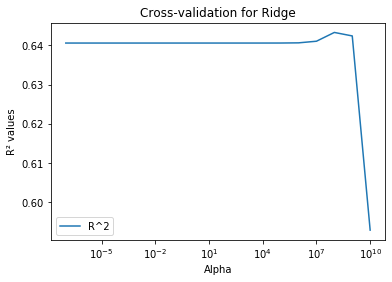

In [271]:
values_rr.set_index('alpha').plot()
plt.title("Cross-validation for Ridge")
plt.xlabel("Alpha")
plt.ylabel("R\u00b2 values")
plt.xscale('log')
plt.savefig('CrossValRidge.png')

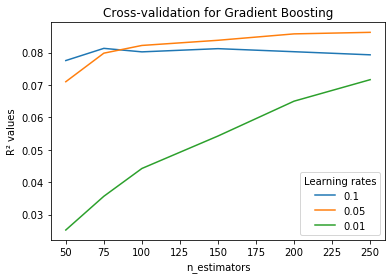

In [272]:
for lr in learning_rates :
    values_gbr[values_gbr['learning_rate'] == lr].set_index('n_estimators')['R^2'].plot(label = str(lr))
plt.xlabel('n_estimators')
plt.ylabel('R\u00b2 values')
plt.title("Cross-validation for Gradient Boosting")
plt.legend(title = 'Learning rates')
plt.savefig('CrossValGBR.png')

We can see that the best hyperparameters are $10^{10}$ for Ridge and $0.05$ and $250$ for Gradient Boosting.

## Plot the best model's prediction

We will train the model with the hyperparameters found above, then predict the output for the test set and finally plot those results to see how they compare to the actual values of the output of the test set.

In [273]:
best_gbr = GradientBoostingRegressor(n_estimators = 250, learning_rate = 0.05)
best_gbr.fit(train_x, train_y)
best_pred_gbr = best_gbr.predict(test_x)

In [282]:
best_rr = Ridge(alpha = 10 ** 10)
best_rr.fit(train_x, train_y)
best_pred_rr = best_rr.predict(test_x)

In [283]:
testset['rr_pred'] = best_pred_rr
testset['gbr_pred'] = best_pred_gbr

Let's try to see if there exists a link between the $R^2$ score of our predictions and the number of followers each ego has in 2020.

In [284]:
nb_followers = np.logspace(0, 6, 7)
r2set = pd.DataFrame({'followers' : [], 'r2gbr' : [], 'r2rr' : []})
for f in nb_followers :
    temp_df = testset[testset['followers_count_2020'] >= f]
    if not temp_df.empty :
        r2gbr = r2_score(temp_df[output], temp_df['gbr_pred'])
        r2rr = r2_score(temp_df[output], temp_df['rr_pred'])
        new_entry = {'followers' : f, 'r2gbr' : r2gbr, 'r2rr' : r2rr}
        r2set = r2set.append(new_entry, ignore_index = True)
r2set

,followers,r2gbr,r2rr
0,1.0,0.453854,-1.171982
1,10.0,0.435608,-1.237036
2,100.0,0.398841,-1.569107
3,1000.0,0.448737,-2.768761
4,10000.0,-0.158905,-51.730184


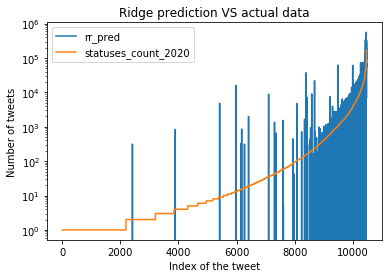

In [285]:
all_pred = testset[['statuses_count_2020', 'rr_pred', 'gbr_pred']].sort_values(by = 'statuses_count_2020')
all_pred.set_index(np.arange(0, all_pred.shape[0]), inplace = True)
all_pred[['rr_pred', 'statuses_count_2020']].plot()
plt.yscale('log')
plt.xlabel('Index of the tweet')
plt.ylabel('Number of tweets')
plt.title('Ridge prediction VS actual data')
plt.savefig('rrpred.png')

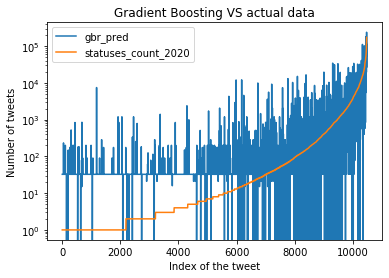

In [279]:
all_pred[['gbr_pred', 'statuses_count_2020']].plot()
plt.yscale('log')
plt.xlabel('Index of the tweet')
plt.ylabel('Number of tweets')
plt.title('Gradient Boosting VS actual data')
plt.savefig('gbrpred.png')

In both cases, results are really bad, it seems it is not easy to predict user's activity based only on data that came form 6 years ago.